In [1]:
# Notebook 1: Reward-Based Tuning
# This notebook assumes you have trained a base model using your clean training pipeline,
# and now want to perform incremental updates based on misclassifications.
import os
import torch
import pandas as pd

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import DataLoader, Dataset
from dataset_utils import PromptDataset  # uses your existing Dataset class
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import ticker

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else
                      "cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [3]:
model_path = "models/roBERTa-Large_best_model_w_tuning_4_14_25"  # update if needed
model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_path)
torch.cuda.empty_cache()
print('done')


done


In [4]:
# load / train test datasets
train_file_path = r"/home/chasesmaker/datasets/train_dataset.csv"
test_file_path = r"/home/chasesmaker/datasets/test_dataset.csv"
failed_prompts_path = "/home/chasesmaker/datasets/failed_prompts_dataset.csv"


train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)
failed_df = pd.read_csv(failed_prompts_path)

# Print dataset samples for verification
print("Train Dataset Sample:")
display(train_df.head())

print("Test Dataset Sample:")
display(test_df.head())

print("Failed Dataset Sample:")
display(failed_df.head())

Train Dataset Sample:


,prompt,class
0,Homer simpson playing ping pong with a sloth w...,image
1,"A donut being licked by a lizard in a winery, ...",image
2,A jug of milk and a donut sitting next to a wo...,image
3,Winnie the pooh playing blackjack and losing i...,image
4,A cup of tea and a pizza made out of plastic i...,image


Test Dataset Sample:


,prompt,class
0,"Digital Art With advancements in technology, c...",image
1,"Fantasy Art With advancements in technology, t...",image
2,"Abstract Art With advancements in technology, ...",image
3,"Digital Art With advancements in technology, m...",image
4,"Fantasy Art With advancements in technology, t...",image


Failed Dataset Sample:


,prompt,class
0,generate me an image,image
1,generate an image of homer simpson,image
2,draw master chief,image
3,write an essay about a pretty picture of a sunset,text
4,draw a picture of a the declaration of the ind...,image


Index(['text', 'image'], dtype='object', name='class')


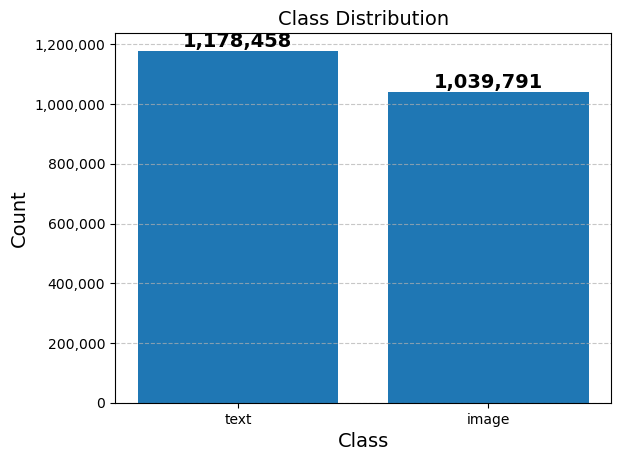

In [5]:
# Class counts
value_counts = train_df['class'].value_counts()
labels = value_counts.index
counts = value_counts.values
print(labels)

# Create the bar chart
#plt.figure(figsize=(8, 6))
bars = plt.bar(labels, counts)

# Add comma-separated labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{height:,}', ha='center', va='bottom', fontweight='bold', fontsize=14)

plt.title('Class Distribution', fontsize=14)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.grid(axis='y', linestyle='--', alpha=0.7)
#plt.tight_layout()
#plt.show()

In [6]:
# Encode labels (1 for Text, 0 for Image)
label2id = {"image": 0, "text": 1}
id2label = {0: "image", 1: "text"}

# Standardize and map labels
train_df['label'] = train_df['class'].str.lower().map(label2id)
test_df['label'] = test_df['class'].str.lower().map(label2id)
failed_df['label'] = failed_df['class'].str.lower().map(label2id)

# Extract features and labels
x_train= train_df['prompt']
y_train = train_df['label']

x_test = test_df['prompt']
y_test = test_df['label']

x_fail = failed_df['prompt']
y_fail = failed_df['label']


print("Train classes:", train_df['class'].unique())
print("Test classes:", test_df['class'].unique())
print("Failed classes:", failed_df['class'].unique())


Train classes: ['image' 'text']
Test classes: ['image' 'text']
Failed classes: ['image' 'text']


In [7]:
from dataset_utils import PromptDataset

train_dataset = PromptDataset(x_train, y_train, tokenizer=tokenizer)

test_dataset = PromptDataset(x_test, y_test, tokenizer=tokenizer)

failed_dataset = PromptDataset(x_fail, y_fail, tokenizer=tokenizer)

In [8]:
pin_memory = True if device.type == "cuda" else False

cpu_count = os.cpu_count()
if device.type == "cuda":
  numWorkers = min(30, cpu_count - 2)
elif device.type == "mps":
  numWorkers = 0
else:
  numWorkers = min(12, cpu_count // 2)

print(f"Device: {device}")
print(f"num_workers: {numWorkers}, pin_memory: {pin_memory}")

Device: cuda
num_workers: 30, pin_memory: True


In [9]:
batchSize= 128

train_loader = DataLoader(
    train_dataset, 
    batch_size=batchSize, 
    shuffle=True, 
    num_workers=numWorkers, 
    pin_memory=pin_memory
)

test_loader = DataLoader(
  test_dataset,
  batch_size=batchSize,
  num_workers=numWorkers,
  pin_memory=pin_memory
)

failed_loader = DataLoader(
  failed_dataset,
  batch_size=batchSize,
  num_workers=numWorkers,
  pin_memory=pin_memory
)
print("Dataloader completed")

Dataloader completed


In [10]:
# Gentle reward function
def compute_reward(preds, labels, red_flag_class_id=1):
    #preds = preds.argmax(dim=1)  # Get predicted class
    rewards = []
    for pred, true_label in zip(preds, labels):
        if true_label == red_flag_class_id:
            rewards.append(1.0 if pred == true_label else -0.5)  # Reward for red-flag class
        else:
            rewards.append(1.0 if pred == true_label else -0.5)  # Reward for other classes
    return torch.tensor(rewards).to(device)

In [11]:
def fine_tune_with_rewards(model, dataloader, optimizer, reward_function, batch_size=32):
    model.train()
    total_loss = 0.0
    loss_fn = torch.nn.CrossEntropyLoss(reduction="none")

    for batch in tqdm(dataloader, desc="Fine-Tuning with Rewards"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        rewards = reward_function(preds, labels).to(device)  # Shape: [batch_size]

        ce_loss = loss_fn(logits, labels)  # Shape: [batch_size]
        scaled_loss = torch.mean(rewards * ce_loss)  # Reward-weighted loss

        scaled_loss.backward()
        optimizer.step()

        total_loss += scaled_loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Average reward-weighted loss: {avg_loss:.4f}")
    return model, optimizer


In [12]:
def evaluate_and_get_misclassified(model, dataloader):
    model.eval()
    predictions, true_labels, misclassified = [], [], []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

            # Track misclassified samples
            for i in range(len(preds)):
                if preds[i] != labels[i]:
                    misclassified.append({
                        'text': tokenizer.decode(input_ids[i], skip_special_tokens=True),
                        'true': labels[i].item(),
                        'pred': preds[i].item()
                    })

    acc = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted')

    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    return misclassified


In [13]:
# Main function for training and evaluation loop
def train_and_evaluate_with_rewards(
    model,
    misclassified_samples,
    test_loader,
    optimizer,
    reward_function,
    tokenizer,
    batchSize=16,
    numWorkers=2,
    pin_memory=True,
    failed_prompts_path="failed_prompts_dataset.csv"
):
    # Append new misclassified samples to file if any
    if len(misclassified_samples) > 22:
        new_df = pd.DataFrame(misclassified_samples)
        if os.path.exists(failed_prompts_path):
            existing_df = pd.read_csv(failed_prompts_path)
            combined_df = pd.concat([existing_df, new_df], ignore_index=True).drop_duplicates(subset=['text'])
        else:
            combined_df = new_df
        combined_df.to_csv(failed_prompts_path, index=False)
        print(f"Saved {len(new_df)} new misclassified samples. Total now: {len(combined_df)}")
    else:
        print("No new misclassified samples provided.")

    # Load misclassified prompts dataset
    if not os.path.exists(failed_prompts_path):
        print("No failed prompts dataset found. Skipping fine-tuning.")
        return model, optimizer

    misclassified_df = pd.read_csv(failed_prompts_path)
    print(f"Loaded {len(misclassified_df)} previously misclassified samples.")


    # Prepare the dataset like you do for train/test
    label2id = {"image": 0, "text": 1}  # Ensure consistent mapping
    misclassified_df['label'] = misclassified_df['true'].map(int)  # assuming true is already 0 or 1

    x_failed = misclassified_df['text']
    y_failed = misclassified_df['label']

    failed_dataset = PromptDataset(x_failed, y_failed, tokenizer)
    failed_loader = DataLoader(
        failed_dataset,
        batch_size=batchSize,
        shuffle=True,
        num_workers=numWorkers,
        pin_memory=pin_memory
    )

    # Fine-tune on misclassified samples
    print(f"Fine-tuning on {len(misclassified_df)} misclassified prompts...")
    model, optimizer = fine_tune_with_rewards(model, failed_loader, optimizer, reward_function)

    # Re-evaluate after tuning
    misclassified_samples_after_tune = evaluate_and_get_misclassified(model, test_loader)
    print(f"Misclassified samples after fine-tuning: {len(misclassified_samples_after_tune)}")

    return model, optimizer


In [14]:
# Initialize optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)


In [15]:
# Evaluate on the test set and get misclassified samples
misclassified_samples = evaluate_and_get_misclassified(model, train_loader)
print(f"Misclassified samples: {len(misclassified_samples)}")

Evaluating: 100%|██████████| 17331/17331 [1:43:31<00:00,  2.79it/s]


Accuracy: 0.9974
F1 Score: 0.9974
Misclassified samples: 5695


In [16]:
# Train and evaluate the model using the reward function
model, optimizer = train_and_evaluate_with_rewards(
    model, 
    misclassified_samples,  
    train_loader, 
    optimizer, 
    compute_reward,
    tokenizer
)

Saved 5695 new misclassified samples. Total now: 3870
Loaded 3870 previously misclassified samples.
Fine-tuning on 3870 misclassified prompts...


Fine-Tuning with Rewards: 100%|██████████| 242/242 [00:41<00:00,  5.82it/s]


Average reward-weighted loss: -4.1546


Evaluating: 100%|██████████| 17331/17331 [1:43:41<00:00,  2.79it/s]


Accuracy: 0.9555
F1 Score: 0.9555
Misclassified samples after fine-tuning: 98727


In [17]:
save_path = "./models/roBERTa-Large_best_model_w_tuning_04_18_25"

In [18]:
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)
print(f"Model saved to {save_path}")
if device == "cuda":
    torch.cuda.empty_cache()

Model saved to ./models/roBERTa-Large_best_model_w_tuning_04_18_25


In [19]:
# Load the saved model
if(os.path.exists(save_path)):
  del model  # Clear memory
  model = AutoModelForSequenceClassification.from_pretrained(save_path).to(device)
  tokenizer = AutoTokenizer.from_pretrained(save_path)
  print("Model loaded successfully.")

Model loaded successfully.


In [20]:
test_path = "results/predictions_tuned_04_18_25.csv"
import torch.nn.functional as F
def test():
  # Evaluate trained model
  model.eval()
  y_pred, y_true = [], []
  with torch.no_grad():
    for batch in tqdm(test_loader, desc="evaluating", unit="batch"):
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['label'].to(device)
      outputs = model(input_ids, attention_mask=attention_mask)
      preds = torch.argmax(F.softmax(outputs.logits.float(), dim=-1), dim=1)
      y_pred.extend(preds.cpu().numpy())
      y_true.extend(labels.cpu().numpy())
  df_test = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
  df_test.to_csv(test_path, index=False)
  print("Predictions saved to predictions_tuned_04_18_25.csv")

if(not os.path.exists(test_path)):
  test()

evaluating: 100%|██████████| 1129/1129 [06:41<00:00,  2.81batch/s]


Predictions saved to predictions_tuned_04_18_25.csv


Loaded predictions from predictions_tuned_04_18_25.csv
Accuracy: 93.33%
F1 Score: 0.94
Confusion Matrix:


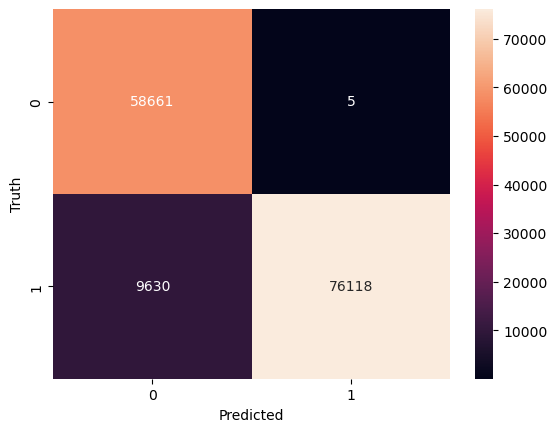

In [21]:
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

if(os.path.exists(test_path)):
  pred_df = pd.read_csv(test_path)
  y_true = pred_df['y_true'].values
  y_pred = pred_df['y_pred'].values
  print("Loaded predictions from predictions_tuned_04_18_25.csv")

  # Metrics
  accuracy = accuracy_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  cm = confusion_matrix(y_true, y_pred)

  print(f"Accuracy: {accuracy * 100:.2f}%")
  print(f"F1 Score: {f1:.2f}")
  print("Confusion Matrix:")
  heatmap = sns.heatmap(cm, annot=True, fmt='d')
  plt.xlabel('Predicted')
  plt.ylabel('Truth')
  # Save the figure
  figure = heatmap.get_figure()
  figure.savefig('confusion_matrix_tuned_04_18_25.png', bbox_inches='tight')
